In [533]:
import pandas as pd
import numpy as np

In [534]:
## tensorflow only used to import MNIST dataset
import tensorflow as tf

# Load MNIST dataset
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Normalize the dataset
x_train, x_test = x_train / 255.0, x_test / 255.0

# Access the images
images = x_train

In [535]:
import numpy as np
import matplotlib.pyplot as plt

def show_image(matrix, y):
    # Ensure the input is a 28x28 NumPy array
    if matrix.shape != (28, 28):
        raise ValueError("Input matrix must be of shape (28, 28)")

    # Display the image
    plt.figure(figsize=(2, 2))
    plt.imshow(matrix, cmap='gray', interpolation='nearest')
    plt.title(f"Labled as {y}")
    plt.colorbar()  # Optional: to show the color scale
    plt.show()

images_2_show.shape:
float64


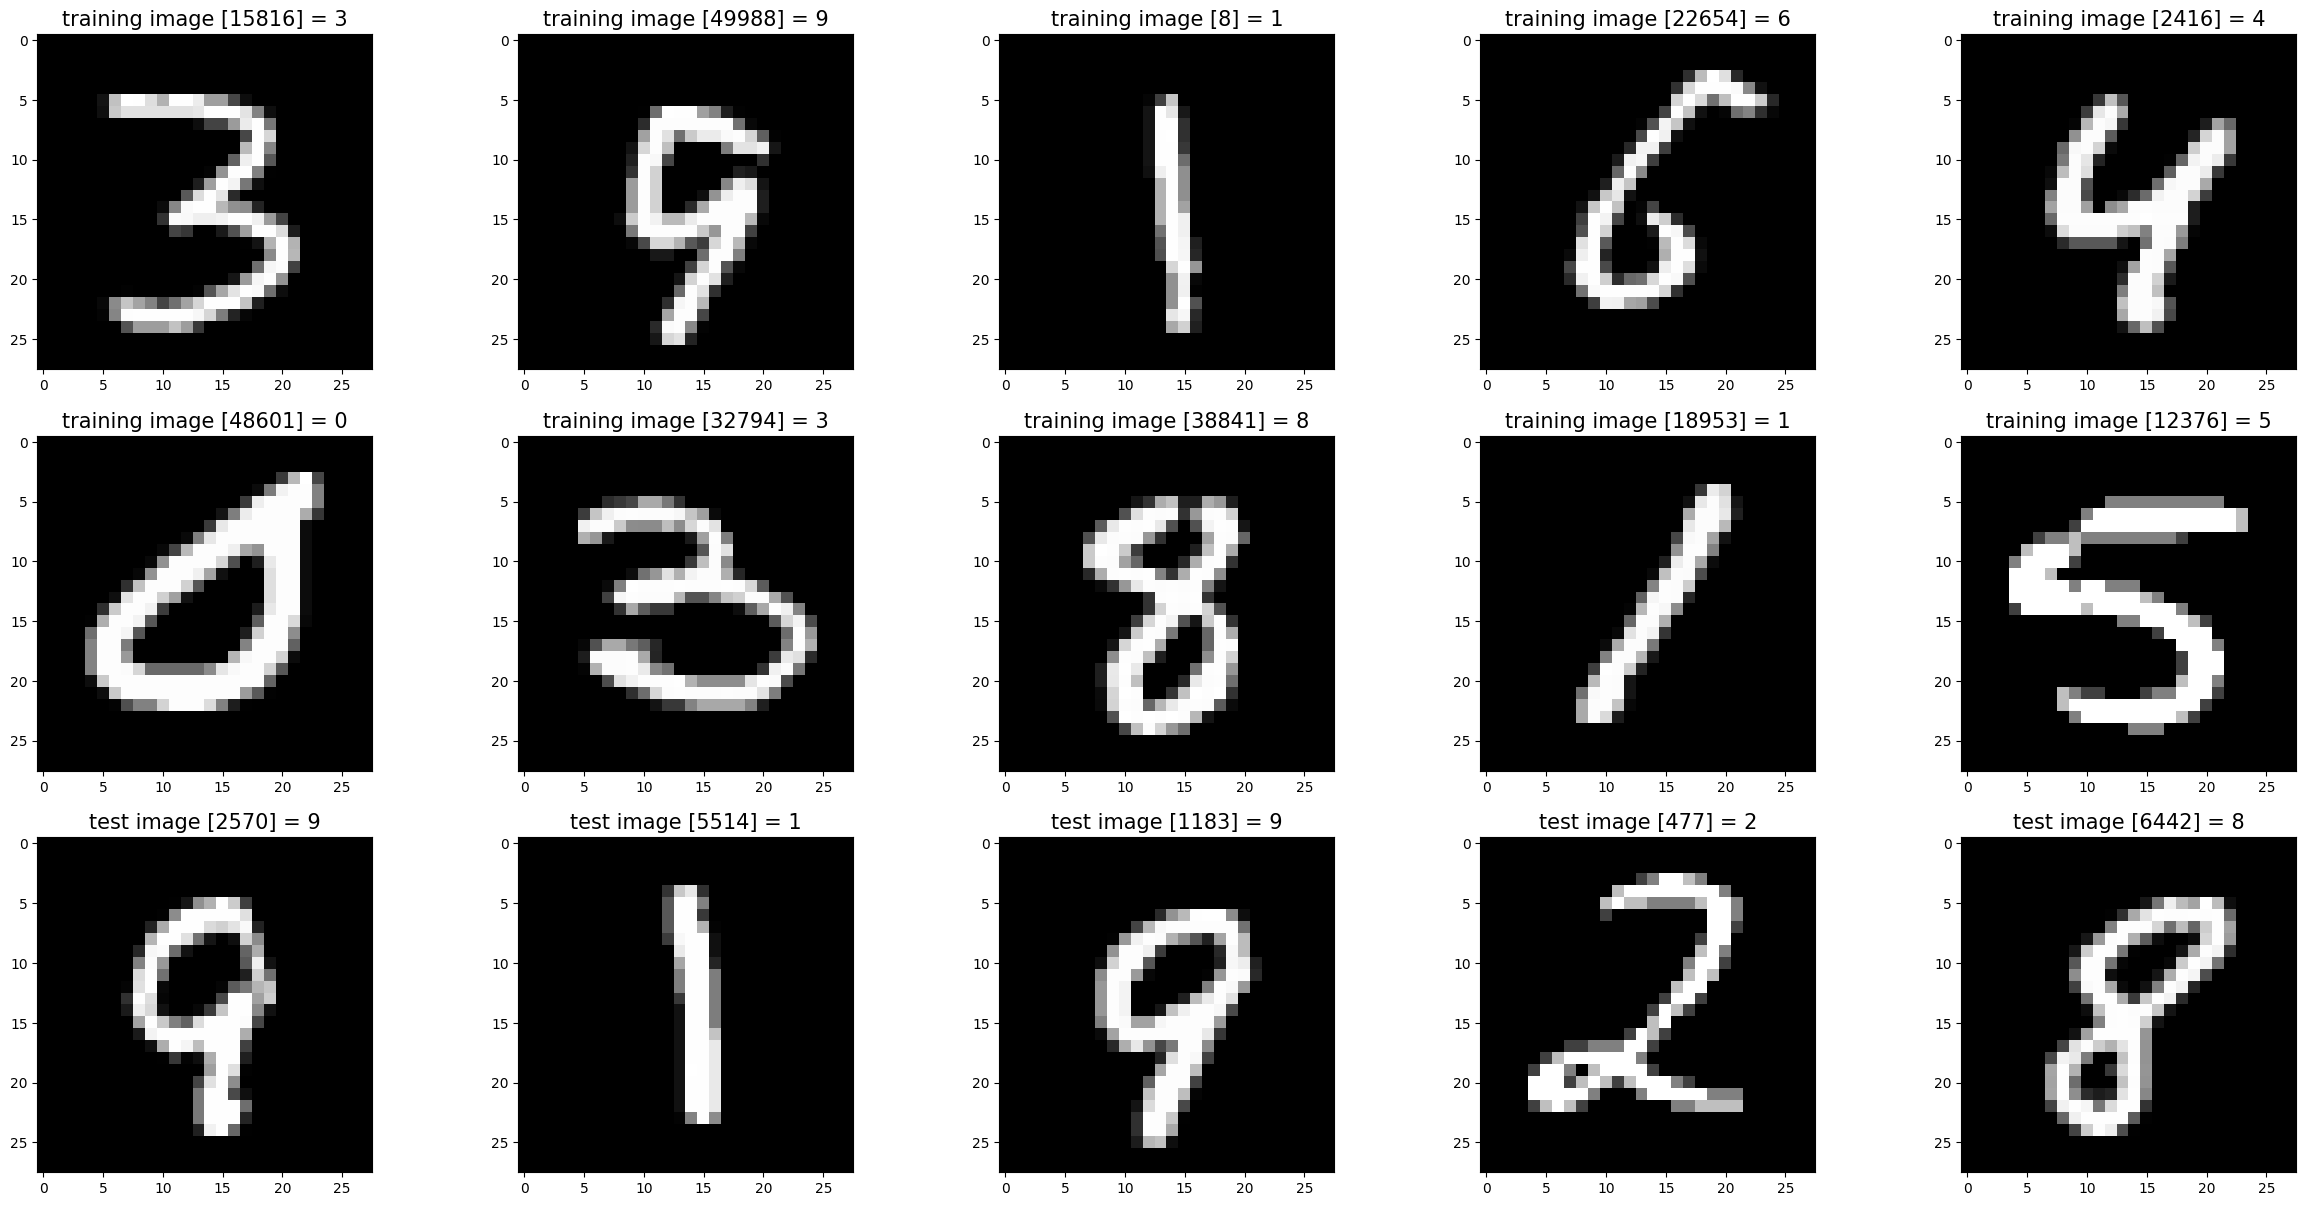

In [536]:
## code to show images taken from kaggle: https://www.kaggle.com/datasets/hojjatk/mnist-dataset
import matplotlib.pyplot as plt
import random

def show_images(images, title_texts):
    cols = 5
    rows = int(len(images)/cols) + 1
    plt.figure(figsize=(30,20))
    index = 1
    for x in zip(images, title_texts):
        image = x[0]
        title_text = x[1]
        plt.subplot(rows, cols, index)
        plt.imshow(image, cmap=plt.cm.gray)
        if (title_text != ''):
            plt.title(title_text, fontsize = 15);
        index += 1
#
# Show some random training and test images
#
images_2_show = []
titles_2_show = []
for i in range(0, 10):
    r = random.randint(1, 60000)
    images_2_show.append(x_train[r])
    titles_2_show.append('training image [' + str(r) + '] = ' + str(y_train[r]))

for i in range(0, 5):
    r = random.randint(1, 10000)
    images_2_show.append(x_test[r])
    titles_2_show.append('test image [' + str(r) + '] = ' + str(y_test[r]))

show_images(images_2_show, titles_2_show)
print("images_2_show.shape:")
print(images_2_show[0].dtype)

In [537]:
x_train.shape

(60000, 28, 28)

In [538]:
y_train.shape

(60000,)

In [539]:
## 1 hot encoding single example
# x is a scalar
def one_hot_encode(x):
  vector = np.zeros((10, 1))
  vector[x-1] = 1
  return vector

In [540]:
# 1h encode y_train
y_train_labels = one_hot_encode(y_train[0])
for ex in y_train[1:]:
  y_train_labels = np.hstack((y_train_labels, one_hot_encode(ex)))

print(y_train_labels.shape)

# 1h encode y_test
y_test_labels = one_hot_encode(y_test[0])
for ex in y_test[1:]:
  y_test_labels = np.hstack((y_test_labels, one_hot_encode(ex)))

print(y_test_labels.shape)

(10, 60000)
(10, 10000)


In [541]:
x_train_final = x_train.reshape(60000, 28 * 28)
x_train_final.shape

(60000, 784)

In [542]:
x_test.shape

(10000, 28, 28)

In [543]:
x_test_final = x_test.reshape(10000, 28 * 28)
x_test_final.shape

(10000, 784)

In [544]:
# structure of nn will be 784 -> 20 -> 10
nodes_l0 = 784
nodes_l1 = 20
nodes_l2 = 10

In [545]:
# define random weights, biases
np.random.seed(42)
original_theta = np.random.rand(nodes_l1 + nodes_l2 + (nodes_l0*nodes_l1) + (nodes_l1*nodes_l2)).reshape(-1, 1)
theta = original_theta.copy()

# these variables function as pointers to the relevent entries of theta
bias_l1 = theta[0:nodes_l1]
bias_l1 = bias_l1.reshape(nodes_l1, 1)
bias_l2 = theta[nodes_l1:(nodes_l1+nodes_l2)]
bias_l2 = bias_l2.reshape(nodes_l2, 1)
weights_l1 = theta[(nodes_l1+nodes_l2):((nodes_l1+nodes_l2)+(nodes_l0*nodes_l1))]
weights_l1 = weights_l1.reshape(nodes_l0, nodes_l1)
weights_l1 = weights_l1.transpose()
weights_l2 = theta[((nodes_l1+nodes_l2)+(nodes_l0*nodes_l1)):]
weights_l2 = weights_l2.reshape(nodes_l1, nodes_l2)
weights_l2 = weights_l2.transpose()

print(theta.size)
print(bias_l1.size)
print(bias_l2.size)
print(weights_l1.size)
print(weights_l2.size)
print(bias_l1.size + bias_l2.size + weights_l1.size + weights_l2.size)

15910
20
10
15680
200
15910


In [546]:
def relu(x):
  return np.maximum(0, x)

def relu_prime(x):
  return np.where(x > 0, 1, 0)

In [547]:
# running into overflow with classical implementation
# subtract max for numerical stability - doesn't affect gradients
def softmax_imp(x):
    x_max = np.max(x)
    e_x = np.exp(x - x_max)
    return e_x / np.sum(e_x)

In [548]:
# forward pass through the network
# x is a vector of length 784
# returns tuple of activations and z's throughout network
def forward_eval(x):
  if x.shape != (nodes_l0, 1):
    print("Input wrong dimension")
    return -1

  a0 = x

  z1 = (weights_l1 @ a0) + bias_l1
  a1 = relu(z1)

  z2 = (weights_l2 @ a1) + bias_l2
  a2 = softmax_imp(z2)

  return x, a0, z1, a1, z2, a2

In [549]:
# backpropagation calculations - find grad of example i
def backprop(input, label):
    x, a0, z1, a1, z2, a2 = forward_eval(input)

    if label.shape != (nodes_l2, 1):
        print("Shape of label wrong size:")
        print(label.shape)
        return -1

    # Corrected error calculation for last layer
    error_l2 = a2 - label  # Softmax with cross-entropy loss
    error_l1 = np.dot(weights_l2.T, error_l2) * relu_prime(z1)

    grad = np.zeros_like(theta)
    grad[0:nodes_l1] = np.mean(error_l1, axis=1).reshape(nodes_l1, 1)  # bias 1
    grad[nodes_l1:(nodes_l1 + nodes_l2)] = np.mean(error_l2, axis=1).reshape(nodes_l2, 1)  # bias 2

    w1 = np.dot(error_l1, a0.T)
    w2 = np.dot(error_l2, a1.T)
    flattened_w1 = w1.flatten(order='F').reshape(-1, 1)
    flattened_w2 = w2.flatten(order='F').reshape(-1, 1)

    grad[(nodes_l1 + nodes_l2):(nodes_l1 + nodes_l2 + flattened_w1.size)] = flattened_w1
    grad[(nodes_l1 + nodes_l2 + flattened_w1.size):] = flattened_w2

    return grad, np.mean(np.abs(z2 - label))



In [550]:
# gradient descent
def gradient_descent(learning_rate, X, y):
    global theta

    gradients = np.zeros_like(theta)
    costs = []

    # gather matrix of gradients from each example i
    for i in range(X.shape[0]):
        grad, cost = backprop(X[i, :].reshape(784, 1), y[:, i].reshape(-1, 1))
        gradients += grad
        costs.append(cost)

    # average -> obtain final gradient -> update theta
    gradients /= X.shape[0]
    theta -= learning_rate * gradients

    print(f"Updated theta with lr {learning_rate}")
    print(f"Average cost of these examples: {np.mean(costs)}")

    return np.mean(costs)


In [551]:
# x_train_final, y_train_labels, x_test_final, y_test_labels

In [552]:
import random
import matplotlib.pyplot as plt
## Train network
def train(schedule, X, y):
  costs_list = []
  for learning_rate in schedule:
    # chose 32 random examples to use to calculate gradient each epoch
    examples = random.sample(range(X.shape[0]), 64)
    X_sgd = X[examples, :]
    y_sgd = y[:, examples]
    cost = gradient_descent(learning_rate, X_sgd, y_sgd)
    costs_list.append(cost)

  # Generate a plot to show how loss changed over epochs
  indices = list(range(len(costs_list)))

  # Create a scatter plot
  plt.scatter(indices, costs_list)
  plt.xlabel('Index')
  plt.ylabel('Value')
  plt.title('Scatter Plot of Average Loss Over Epochs')
  plt.show()

In [553]:
print(x_train_final.shape)
print(y_train_labels.shape)

(60000, 784)
(10, 60000)


Updated theta with lr 0.01
Average cost of these examples: 470.525575120398
Updated theta with lr 0.01
Average cost of these examples: 438.807777045143
Updated theta with lr 0.01
Average cost of these examples: 441.7907808750556
Updated theta with lr 0.01
Average cost of these examples: 461.18500959630074
Updated theta with lr 0.01
Average cost of these examples: 436.548717074881
Updated theta with lr 0.01
Average cost of these examples: 484.4547716247166
Updated theta with lr 0.01
Average cost of these examples: 456.7597851288575
Updated theta with lr 0.01
Average cost of these examples: 473.0042420652071
Updated theta with lr 0.01
Average cost of these examples: 468.28264274421474
Updated theta with lr 0.01
Average cost of these examples: 461.269004482479
Updated theta with lr 0.01
Average cost of these examples: 456.3246830886401
Updated theta with lr 0.01
Average cost of these examples: 445.77486227970627
Updated theta with lr 0.01
Average cost of these examples: 477.3277553640465


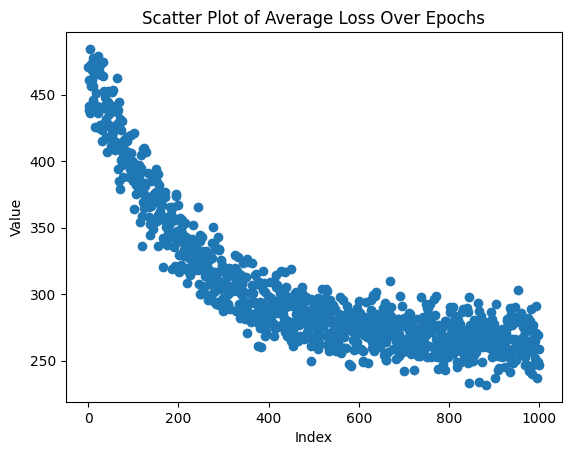

In [554]:
# epochs
schedule = np.full(1000, 0.01)

# Concatenate the two vectors
#schedule = np.concatenate((vector_1, vector_2))

train(schedule, x_train_final, y_train_labels)

In [555]:
# predict single test example using network
def predict(x, y):
  if x.shape != (nodes_l0, 1):
    print("input wrong size")
    return -1

  z0_, a0_, z1_, a1_, z2_, a2_ = forward_eval(x)

  prediction = (np.argmax(a2_) + 1)%10

  print(f"prediction: {prediction}")
  print("distribution:")
  print(a2_)
  show_image(x.reshape(1, 28, 28)[0], y)

def predict_for_scoring(x):
  if x.shape != (nodes_l0, 1):
    print("input wrong size")
    return -1

  z0_, a0_, z1_, a1_, z2_, a2_ = forward_eval(x)

  prediction = (np.argmax(a2_) + 1)%10
  return prediction


In [556]:
original_theta

array([[0.37454012],
       [0.95071431],
       [0.73199394],
       ...,
       [0.14418946],
       [0.20440377],
       [0.24626572]])

In [557]:
theta

array([[-0.40606195],
       [ 0.43011278],
       [ 0.10895235],
       ...,
       [-0.41106221],
       [ 0.98190001],
       [ 1.02017274]])

prediction: 7
distribution:
[[6.95122521e-26]
 [4.32602861e-23]
 [3.60371549e-15]
 [2.93412728e-18]
 [2.04940132e-15]
 [1.06443762e-30]
 [9.99999661e-01]
 [8.16205056e-20]
 [3.39474816e-07]
 [8.17450672e-16]]


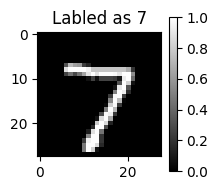

prediction: 2
distribution:
[[2.36209738e-20]
 [9.99999979e-01]
 [9.10198075e-12]
 [2.36328529e-24]
 [2.04202911e-08]
 [9.28240813e-11]
 [6.25954195e-33]
 [3.78742522e-19]
 [6.35498297e-26]
 [2.55761561e-16]]


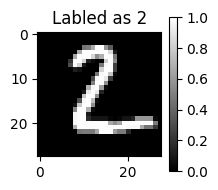

prediction: 1
distribution:
[[9.99999756e-01]
 [1.83608550e-09]
 [2.13382282e-07]
 [3.36085562e-09]
 [5.85373130e-09]
 [1.88154887e-12]
 [2.94576495e-10]
 [1.48218831e-08]
 [4.45687607e-09]
 [2.70512769e-23]]


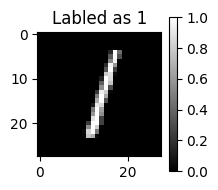

prediction: 0
distribution:
[[2.38910717e-40]
 [6.09737087e-27]
 [1.73423726e-28]
 [1.24531673e-25]
 [2.21306100e-10]
 [4.26655265e-21]
 [2.79851014e-23]
 [1.44772616e-29]
 [7.10671581e-22]
 [1.00000000e+00]]


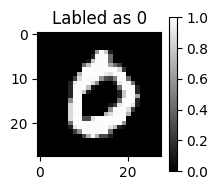

prediction: 4
distribution:
[[7.11250778e-13]
 [5.70739263e-08]
 [9.68527612e-15]
 [8.80217945e-01]
 [1.56771610e-07]
 [3.90596974e-08]
 [2.05553352e-05]
 [1.50023053e-06]
 [1.19759745e-01]
 [1.57595414e-09]]


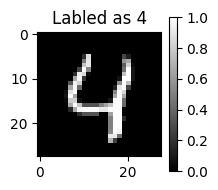

prediction: 1
distribution:
[[9.99999993e-01]
 [3.19035396e-14]
 [7.22091380e-09]
 [1.65586561e-13]
 [2.80560304e-12]
 [2.65050801e-20]
 [2.76047935e-13]
 [1.80788893e-12]
 [7.92107814e-11]
 [1.84006822e-31]]


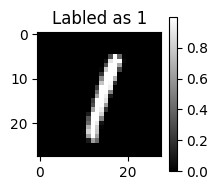

prediction: 4
distribution:
[[2.44009649e-07]
 [1.22225369e-14]
 [1.20065390e-07]
 [8.46956849e-01]
 [1.73580610e-03]
 [3.41846265e-14]
 [1.90811492e-03]
 [6.59616112e-02]
 [8.34372542e-02]
 [1.26469669e-15]]


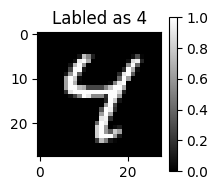

prediction: 4
distribution:
[[2.28387560e-01]
 [4.23070267e-08]
 [2.36927204e-07]
 [5.49474639e-01]
 [8.85812785e-02]
 [5.99509194e-08]
 [6.86848452e-09]
 [1.04373397e-04]
 [1.33451803e-01]
 [6.24862740e-21]]


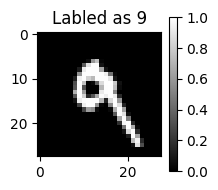

prediction: 2
distribution:
[[6.21682466e-09]
 [6.45626401e-01]
 [5.97498113e-16]
 [6.37512300e-02]
 [2.60949250e-01]
 [2.96572585e-02]
 [8.04979506e-15]
 [2.30376245e-09]
 [1.57764405e-05]
 [7.57982758e-08]]


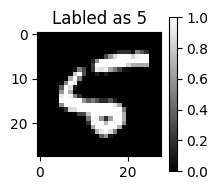

prediction: 9
distribution:
[[5.72186973e-19]
 [3.78739799e-26]
 [6.16400361e-21]
 [1.93080498e-05]
 [1.25364100e-11]
 [3.50620345e-22]
 [2.02274386e-04]
 [6.22285850e-16]
 [9.99778418e-01]
 [2.37849132e-21]]


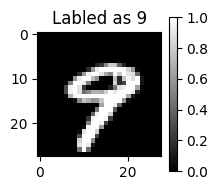

prediction: 0
distribution:
[[2.17241814e-38]
 [9.76429762e-21]
 [6.67501492e-25]
 [1.31474324e-34]
 [3.17305925e-12]
 [3.01216642e-30]
 [6.96980865e-38]
 [2.02884891e-23]
 [1.17782352e-37]
 [1.00000000e+00]]


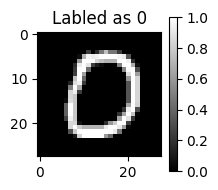

prediction: 5
distribution:
[[5.84176409e-10]
 [8.76454156e-08]
 [8.81238365e-17]
 [1.70133953e-07]
 [9.99659015e-01]
 [2.43195408e-06]
 [1.62484139e-19]
 [3.37935620e-04]
 [1.47976638e-11]
 [3.58656592e-07]]


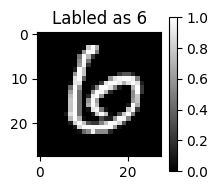

prediction: 9
distribution:
[[5.97753868e-19]
 [3.83496269e-18]
 [1.23090706e-20]
 [7.41532420e-05]
 [2.83342527e-13]
 [3.84770168e-19]
 [2.90573585e-08]
 [2.06586869e-13]
 [9.99925818e-01]
 [3.97765195e-16]]


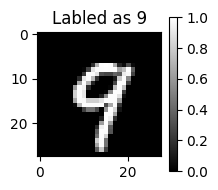

prediction: 0
distribution:
[[1.35769120e-35]
 [2.43567432e-27]
 [2.59819349e-26]
 [5.43005000e-24]
 [5.43900342e-11]
 [2.22761397e-29]
 [5.25258759e-27]
 [1.43877708e-19]
 [1.84611202e-20]
 [1.00000000e+00]]


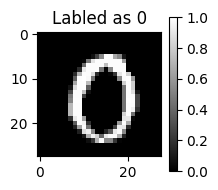

prediction: 1
distribution:
[[9.99999984e-01]
 [3.71588154e-13]
 [1.04941147e-08]
 [1.16292953e-14]
 [9.42179636e-10]
 [1.31008479e-17]
 [1.74151106e-10]
 [1.48805831e-10]
 [3.79791850e-09]
 [3.14269252e-29]]


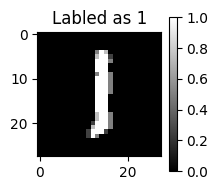

prediction: 5
distribution:
[[7.11192704e-16]
 [4.16804418e-09]
 [1.88708414e-03]
 [1.37216945e-13]
 [9.98040720e-01]
 [1.14735738e-14]
 [4.82916031e-17]
 [6.15509379e-11]
 [1.02227676e-15]
 [7.21918855e-05]]


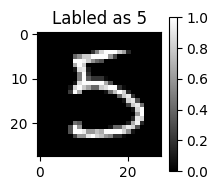

prediction: 9
distribution:
[[4.59985824e-17]
 [3.81361565e-15]
 [6.85512946e-18]
 [8.43781983e-02]
 [1.28565695e-10]
 [1.06352004e-15]
 [3.69285799e-07]
 [1.92605444e-08]
 [9.15621413e-01]
 [1.31389444e-13]]


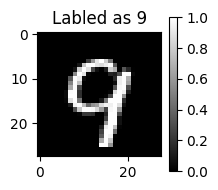

prediction: 7
distribution:
[[1.72141865e-29]
 [2.42456993e-23]
 [4.89957653e-12]
 [1.81207155e-21]
 [2.64170243e-13]
 [3.05464282e-32]
 [1.00000000e+00]
 [1.87315803e-22]
 [9.29993945e-11]
 [8.21870579e-14]]


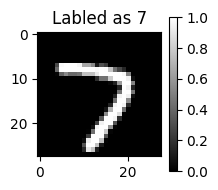

prediction: 5
distribution:
[[3.75849335e-14]
 [4.50407183e-04]
 [5.75768166e-05]
 [3.47924438e-14]
 [9.99492016e-01]
 [1.29529643e-10]
 [5.84124311e-17]
 [1.07643056e-13]
 [2.68636837e-13]
 [6.36754911e-25]]


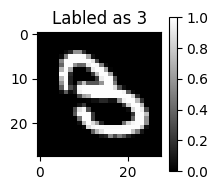

prediction: 4
distribution:
[[3.02215431e-12]
 [6.49094959e-16]
 [4.29557848e-17]
 [9.99986570e-01]
 [4.86789674e-10]
 [2.12492601e-10]
 [3.28771897e-15]
 [2.76938957e-10]
 [1.34293302e-05]
 [8.82429705e-17]]


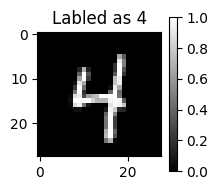

In [558]:
predict(x_test_final[0][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 0].reshape(-1, 1))+1)%10))
predict(x_test_final[1][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 1].reshape(-1, 1))+1)%10))
predict(x_test_final[2][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 2].reshape(-1, 1))+1)%10))
predict(x_test_final[3][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 3].reshape(-1, 1))+1)%10))
predict(x_test_final[4][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 4].reshape(-1, 1))+1)%10))
predict(x_test_final[5][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 5].reshape(-1, 1))+1)%10))
predict(x_test_final[6][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 6].reshape(-1, 1))+1)%10))
predict(x_test_final[7][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 7].reshape(-1, 1))+1)%10))
predict(x_test_final[8][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 8].reshape(-1, 1))+1)%10))
predict(x_test_final[9][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 9].reshape(-1, 1))+1)%10))
predict(x_test_final[10][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 10].reshape(-1, 1))+1)%10))
predict(x_test_final[11][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 11].reshape(-1, 1))+1)%10))
predict(x_test_final[12][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 12].reshape(-1, 1))+1)%10))
predict(x_test_final[13][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 13].reshape(-1, 1))+1)%10))
predict(x_test_final[14][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 14].reshape(-1, 1))+1)%10))
predict(x_test_final[15][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 15].reshape(-1, 1))+1)%10))
predict(x_test_final[16][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 16].reshape(-1, 1))+1)%10))
predict(x_test_final[17][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 17].reshape(-1, 1))+1)%10))
predict(x_test_final[18][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 18].reshape(-1, 1))+1)%10))
predict(x_test_final[19][:].reshape(-1, 1), ((np.argmax(y_test_labels[:, 19].reshape(-1, 1))+1)%10))

[[ 947    0    3    2    0   23    4    1    0    0]
 [   0 1093   16    2    0    5    4    0   15    0]
 [  18   17  889   11   27   19   13   17   17    4]
 [   5   13   48  677    1  212    1    9   16   28]
 [   5   24   11    2  848    7   12    0    2   71]
 [  18   14   17   11   29  766   11   11    6    9]
 [  32    5   36    0   17   56  812    0    0    0]
 [  14   40   34    3   11   14    0  775    3  134]
 [  20   96   64   31   31  195    8    3  468   58]
 [  13   23   12    8  104   34    0    5    1  809]]


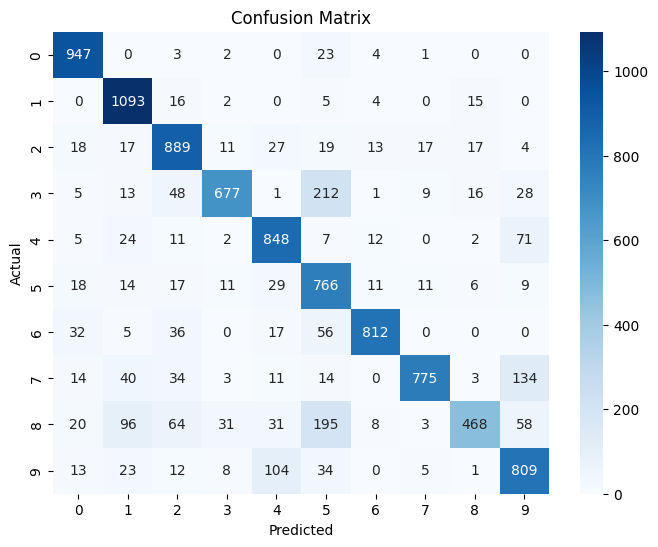


Classification Report:
              precision    recall  f1-score   support

           0     0.8834    0.9663    0.9230       980
           1     0.8249    0.9630    0.8886      1135
           2     0.7867    0.8614    0.8224      1032
           3     0.9063    0.6703    0.7706      1010
           4     0.7940    0.8635    0.8273       982
           5     0.5755    0.8587    0.6892       892
           6     0.9387    0.8476    0.8908       958
           7     0.9440    0.7539    0.8383      1028
           8     0.8864    0.4805    0.6232       974
           9     0.7269    0.8018    0.7625      1009

    accuracy                         0.8084     10000
   macro avg     0.8267    0.8067    0.8036     10000
weighted avg     0.8289    0.8084    0.8059     10000



In [559]:
## Model Accuracy on Unseen Test Data
import numpy as np
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

y_true = []
y_pred = []

for i in range(0, x_test_final.shape[0]):
  y_true.append(((np.argmax(y_test_labels[:, i].reshape(-1, 1))+1)%10))
  y_pred.append(predict_for_scoring(x_test_final[i][:].reshape(-1, 1)))

# Create the confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Print the confusion matrix
print(cm)

# Plot the confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

report = classification_report(y_true, y_pred, digits=4)
print("\nClassification Report:")
print(report)


In [560]:
## NOTES
# idk best practice in Python - fix erorr handling
# note (take out) would optimize this process if fr (backprop calc section)
# how do we use error of layer 0?
# allow learning rate sceduling
# if grad_descent takes too long try mini-batching
# matplotlib visualization about how many of the parameters are w1
# training took. so long. one epoch took over 3 minutes on a t4. need to optimize. started by implementing mini-batching
# changed to selecting 32 random examples to train on for each of 200 epochs. This model trained in 5 seconds on GPUs and produced predictions of '8' for every single example
# implemented a print line that tells me the cost for each batch of examples - not improving - something wrong with gradient equations I think
# takeaways - hyperparameter tuning is even more important than I thought